# Top Ten Words in Tweets 
### Curated Stopwords Removed

### Global parameters 

You will need to have set up a [Karst account](https://kb.iu.edu/d/bezu#account) first. Once you have your Karst account simply go to [rstudio.iu.edu](https://rstudio.iu.edu/auth-sign-in) and login using your IU username and passphrase.  Next, set the working directory by pointing to the location on Karst where you have stored the files. Below, we have chosen to save the folder "Text-Analysis" as a "Project" in R Studio on the Karst super-computer here at Indiana University. It contains the R scripts, texts, notebooks, and results. If you have forked and cloned the Github repository (see [textPrep.Rmd](textPrep.Rmd) for directions on how), simply point to where you have saved the folder. If you save it to your personal Karst folder, it will most likely look very similar to the example below. Karst is a unix server and so the home directory is represented by a ~ and, thus, the path will look like this "~/Text-Analysis/" (with the quotes). Alternatively, if you are on a PC, you will need to use an absolute path such as "C:/Users/XXX" (with the quotes again).

In R Studio, click Session in the menu bar > Set Working Directory > Choose Directory, then select the Text-Analysis directory in which you are working. This will set your working directory in the console pane, but make sure to copy the path into the source pane above to keep the directory constant if you close this script and reopen later. Make sure you click on the blue cube with a "R" in the center to set your working directory to your Text-Analysis project path.

HINT: Your working directory is the folder from which you will be pulling your texts.

In [1]:
#Set the working directory
setwd("~/Text-Analysis/")

#### Include necessary packages for notebook 

R's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of R, others created by R users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In R Studio, packages can be installed by navigating to Tools in the menu bar > Install Packages. Or in the bottom right panel click on the "packages" tab and then click on "install."

- **NLP:** Basic classes and methods for Natural Language Processing.

- **tm:** this package provides tools (functions) for performing various types of text mining. In this script, we will use tm to performing text cleaning in order to have uniform data for analysis. Check out [this link](https://cran.r-project.org/web/packages/tm/vignettes/tm.pdf) for the documentation!
- **tidyverse:** The tidyverse is an opinionated collection of R packages designed for data science. All packages share an underlying design philosophy, grammar, and data structures. Check out [this link](https://www.tidyverse.org/) for more information.

In [2]:
#Call libraries used in the script
library(NLP)
library(tm)
library(dplyr)
library(tidytext)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Here we add a line for extracting a .zip file. This step may not be needed as you can unzip files in the directory manually. However, if you are using rstudio on a server, you will need this step in order to extract the zipped file and then use it.

In [3]:
#unzip file
#zipF<- "data/twitter/neverAgain.csv.zip"
#outDir<-"data/twitter"
#unzip(zipF,exdir=outDir)

Read the .csv file (this time a curated set of tweets grabbed using the #Tags tool, then saved as a .csv file)

In [4]:
#Read in the text 
tweets <- read.csv("data/twitter/neverAgain.csv")

### Prepare text data

First we are going to take the list of 50k+ tweets created when we grabbed the file above and convert it to utf-8 encoding, grabbing only the text column. We use 'iconv' to convert the column labeled 'text' found in our 'tweets' variable above (tweets$text) and then tell it we want to convert the text to = utf-8.

In [5]:
corpus <- iconv(tweets$text, to = "utf-8")

Let's look at the first few tweets:

In [6]:
head(corpus)

[1] "RT @canarymission: Students of Students for Justice in Palestine Mock the #Holocaust \n\n#NeverAgain #WeRemember\nhttps://t.co/cnPE7dEnik https://t.co/Xvd6IBiSPe"                                                                                                                                                                                         
[2] "RT @canarymission: Students of Students for Justice in Palestine Mock the #Holocaust \n\n#NeverAgain #WeRemember\nhttps://t.co/cnPE7dEnik https://t.co/Xvd6IBiSPe"                                                                                                                                                                                         
[3] "He duped so many #NeverAgain #MeToo https://t.co/7u4Vl5UjSR"                                                                                                                                                                                                                                                                                               
[4] "#NeverAgain #NeverForget \U0001f64f\U0001f3fc https://t.co/TuSZLe5dBb"                                                                                                                                                                                                                                                                                     
[5] "RT @MrGoalie35: #NeverAgain #NeverForget \U0001f64f\U0001f3fc https://t.co/TuSZLe5dBb"                                                                                                                                                                                                                                                                     
[6] "RT @ITB_MINCOM: #11thFebruary2018 #cameroUn #YouthDay \U0001f602\U0001f92a\U0001f921\n#SouthernCameroons says #NeverAgain\n#WeWillRESIST cameroUn’s #france-sponsored #GENOCIDE #SLAVERY #KLEPTOCRACY #ONGOING in the COUNTRY of #SouthernCameroons #Ambazonia @USEmbYaounde @BBCAfrica @bbcafrique @Reuters @UKinCameroon @dwnews https://t.co/PSSgr1N2PD"

Now we need to turn the text into a Corpus object:

In [7]:
corpus <- VCorpus(VectorSource(corpus))

Next, we need to eliminate any characters that are not UTF-8. If you know the encoding (in this case it usually is ASCII), then put it in the first set of quotes. If you do not, then just put another "UTF-8" so (x, "ASCII", "UTF-8", sub="") or (x, "UTF-8", "UTF-8", sub=""):

In [8]:
corpus <- tm_map(corpus, function(x) iconv(x, "ASCII", "UTF-8", sub=""))

### Clean Tweets
To clean the corpus in this example, we are using the tm package's built in tools to:
1. Convert all the text to lower case, so that "Never" and "never" are not seen as seperate words.
2. Remove all punctuation so that only alphanumeric characters are read.
3. Eliminate numbers, especially if they skew your results any, however, numbers may also be important, so that is why this one is optional.
4. Remove extra white space so what was "well said @emma4change" does not end up as "well said &nbsp;&nbsp;emma4change" but becomes "well said emma4change" (without the extra space).
5. Remove url's so we don't end up with a lot of 'http', 'https', et cetera. We do this by:
    - creating a function that uses regular expressions to remove them
    - then apply that function to our "corpus."
6. Remove stopwords. In our plain text wordcloud, we used tm's options for a wordlist and will be doing the same again. Concatenated onto the list are common twitter words not yet eliminated such as "rt" (retweet), "amp" (&), the subject of our tweets "neveragain", and a couple twitter handles with the "@" removed.

In [9]:
corpus <- tolower(corpus)
corpus <- removePunctuation(corpus)
corpus <- removeNumbers(corpus)
corpus <- stripWhitespace(corpus)
removeURL <- function(x) gsub("http[[:alnum:]]*", "", x)
corpus <- removeURL(corpus)
corpus <- removeWords(corpus, c(stopwords("english"), 'na','amp','rt', 'neveragain', 'dont', 'will', 'see','just', 'emmachange', 'xokarminox'))

### Processing

After the corpus has been cleaned, we can now begin to process the text. The next step is we simply convert our Corpus class object back to a character class object so that we can use the packages from tidyverse.

In [10]:
myCorpus <- as.character(corpus)

Next we turn the tweets which are now a character class object into a data frame (data_frame(myCorpus)). Then we separate the words into tokens (unnest_tokens(word, myCorpus))and finally we count the number of times each word appears and say we want them sorted (count(word, sort = TRUE)). The 'sort' default is FALSE, so it will automatically put them in ascending order if we do not specify that we want the count sorted. If we say 'sort = TRUE' it puts the words in descending order.

In [11]:
#Convert to data frame (helps make plot labeling easier)
freqDF <- data_frame(myCorpus) %>%
unnest_tokens(word, myCorpus) %>%
    count(word, sort = TRUE)

Let's see what our data frame looks like. Using 'head' shows us the first six rows of our dataframe.

In [12]:
head(freqDF)

word,n
difference,6746
now,4814
us,4615
right,4232
never,4154
change,3944


We may sometimes need to remove a row that lists 'na' as a word. This line says that we want to look at our dataframe (freqDF) and remove (-) the 1st row (1) and replace it with nothing (that is why there is nothing after the comma). However, it is commented out so we don't accidentally remove an important frequently occuring word. If you need to change which row is deleted, simply change the '-1' to whichever number row you want to remove. If you need to remove more than one row, simply put "freqDF[-c(1, 6, 10),]" and this will remove rows 1, 6, and 10. 

In [13]:
#freqDF <- freqDF[-1,]

Now let's check our data frame again and see if it removed our row. This is only needed if you removed a row or rows in the step above. Hence, it is commented out.

In [14]:
#head(freqDF)

Now, we are creating a variable that will determine the x-axis tick labels when we plot our bar graph. Make sure the number matches the number in the part of the plot below that says "barplot(head(freqDF$n,10)"

In [15]:
labNames <- head(freqDF$word, 10)

Now we're going to write the 100 most frequent words and their frequency to a csv file so we can see more than the top 10 or 20 words. If you need to see more or less than the 100 most frequent words, simply change the '100' to the number of most frequent words you wish to see. 

In [16]:
write.csv(head(freqDF, 100), "~/freqWordsNeverAgain.csv")

### Results

Finally, we can plot and view the data as a bar graph with the top ten words along the x-axis and the frequency of appearance along the y-axis. 

      [,1]
 [1,]  0.7
 [2,]  1.9
 [3,]  3.1
 [4,]  4.3
 [5,]  5.5
 [6,]  6.7
 [7,]  7.9
 [8,]  9.1
 [9,] 10.3
[10,] 11.5


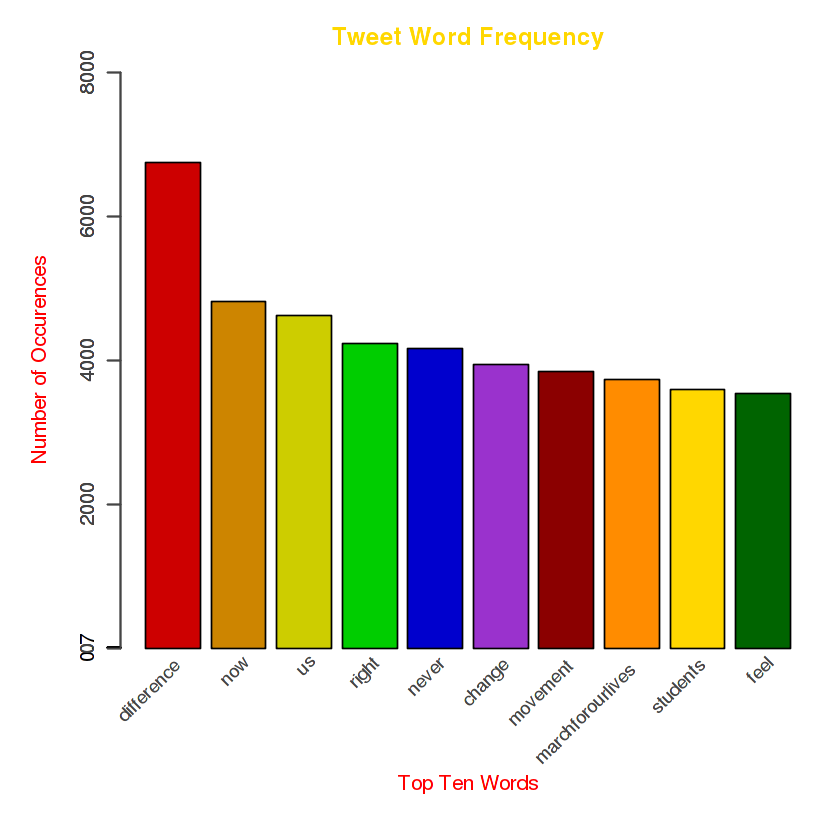

In [17]:
#Remix ideas: 1) Play around with the number of word on the chart by changing it from "10"
# 2) Don't forget to adjust your plot's title if you have changed the input text
# 3) Look up the frequency of all the words in the corpus by typing "freq" into the console

par(mar=c(8,5,3,1))
x <- barplot(head(freqDF$n,10), ylim=c(0,8000), col=c("red3", "orange3","yellow3","green3","blue3","darkorchid3","darkred", "darkorange", "gold", "darkgreen"),col.main="gold", col.lab="red",
     main="Tweet Word Frequency", xlab="", ylab="Number of Occurences", xaxt="n")
axis(2, at=x, labels=TRUE)
axis(2, col="gray27", col.axis="gray27", col.ticks="gray27",labels=TRUE)
text(x, par("usr")[3], srt=45, adj=c(1.1,1.5), xpd = TRUE, labels = labNames, cex=.9, col="gray27")
title(xlab='Top Ten Words', line=5, col.lab="red")
print(x)

### VOILA!